# Exercise 3

## 1 Introduction

Task: Install pytorch (best with conda), convert intro.py into a Jupyter notebook and run the code.

100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100.0%

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100.0%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Epoch: 0
Mean Train Loss: 3.96e-01
Mean Test Loss:  1.47e-01
Epoch: 10
Mean Train Loss: 1.43e-01
Mean Test Loss:  3.03e-01
Epoch: 20
Mean Train Loss: 1.01e-01
Mean Test Loss:  4.11e-01
Epoch: 30
Mean Train Loss: 7.73e-02
Mean Test Loss:  5.25e-01
Epoch: 40
Mean Train Loss: 5.89e-02
Mean Test Loss:  6.82e-01
Epoch: 50
Mean Train Loss: 4.03e-02
Mean Test Loss:  7.97e-01
Epoch: 60
Mean Train Loss: 3.26e-02
Mean Test Loss:  9.04e-01
Epoch: 70
Mean Train Loss: 1.82e-02
Mean Test Loss:  8.31e-01
Epoch: 80
Mean Train Loss: 2.12e-02
Mean Test Loss:  8.73e-01
Epoch: 90
Mean Train Loss: 1.49e-02
Mean Test Loss:  8.87e-01
Epoch: 100
Mean Train Loss: 1.33e-02
Mean Test Loss:  9.60e-01


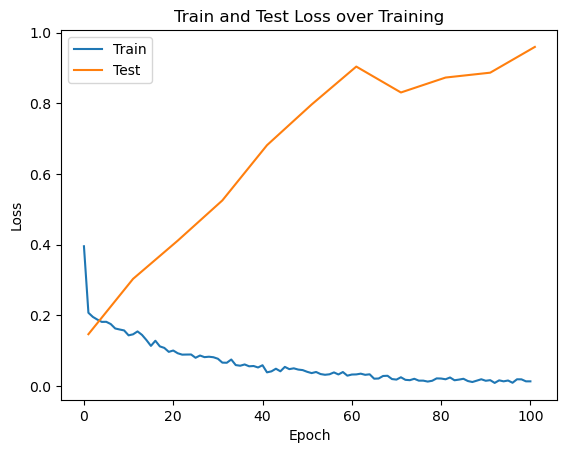

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.legend()


## 2 Dropout

We want to use dropout learning for out network. Therefore, implement the function:

        def dropout(X, p_drop=0.5): ...
        
that sets random elements of X to zero (do not use pytorch's existing dropout functionality).
Dropout:

* If 0< pdrop <1:
    For every element xi ∈ X draw Φi randomly from a binomial distribution with p = pdrop.
    Then reassign
            xi →    {0              if Φ = 1,
                    xi / (1−pdrop)  if Φ = 0}
* Else:
    Return the unchanged X.

In [5]:
def dropout(X, p_drop=0.5):
    if 0 < p_drop < 1:
        # randomly mask elements of X based on binomial distribution
        mask = np.random.binomial(1, p=p_drop, size=X.shape).astype(bool)
        # copy of X is created using X.clone() to avoid modifying the original tensor
        X_drop = X.clone()
        X_drop[mask] = 0
        X_drop /= (1 - p_drop)
        return X_drop
    else:
        return X

You can now enable the dropout functionality. To this end, implement a new model
        
        def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden): ...
        
containing the same fully-connected layers as in function model() of task 1, but now with three dropout steps. Dropout is applied to the input of each layer.

In [6]:
def dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    # apply dropout to the input layer
    x = dropout(x, p_drop_input)

    # first hidden layer
    h = rectify(x @ w_h)
    # apply dropout to the first hidden layer
    h = dropout(h, p_drop_hidden)

    # second hidden layer
    h2 = rectify(h @ w_h2)
    # apply dropout to the second hidden layer
    h2 = dropout(h2, p_drop_hidden)

    # output layer
    pre_softmax = h2 @ w_o
    return pre_softmax

Task: Explain in a few sentences how the dropout method works and how it reduces overfitting. Train the model using dropout and report train and test errors. Why do we need a different model configuration for evaluating the test loss? Compare the test error with the test error from Section 1.


* The dropout model works by randomly setting a part of the neurons to zero on each iteration of the training process. By doing so it drops out those parts and this enables the network to learn more robust and generalized features. The model becomes more independent beacuse it works with neurons that are partly dropped out and it cannot rely on specific neurons. This leads the creation of multiple subnetworks which improves the network's generalization ability and reduces overfitting.

Epoch: 0
Mean Train Loss: 1.64e+00
Mean Test Loss:  6.60e-01
Epoch: 10
Mean Train Loss: 1.69e+00
Mean Test Loss:  7.86e-01
Epoch: 20
Mean Train Loss: 1.77e+00
Mean Test Loss:  5.30e-01
Epoch: 30
Mean Train Loss: 1.75e+00
Mean Test Loss:  5.97e-01
Epoch: 40
Mean Train Loss: 1.72e+00
Mean Test Loss:  6.06e-01
Epoch: 50
Mean Train Loss: 1.69e+00
Mean Test Loss:  6.37e-01
Epoch: 60
Mean Train Loss: 1.74e+00
Mean Test Loss:  6.53e-01
Epoch: 70
Mean Train Loss: 1.75e+00
Mean Test Loss:  6.83e-01
Epoch: 80
Mean Train Loss: 1.75e+00
Mean Test Loss:  6.57e-01
Epoch: 90
Mean Train Loss: 1.72e+00
Mean Test Loss:  5.97e-01
Epoch: 100
Mean Train Loss: 1.86e+00
Mean Test Loss:  6.11e-01


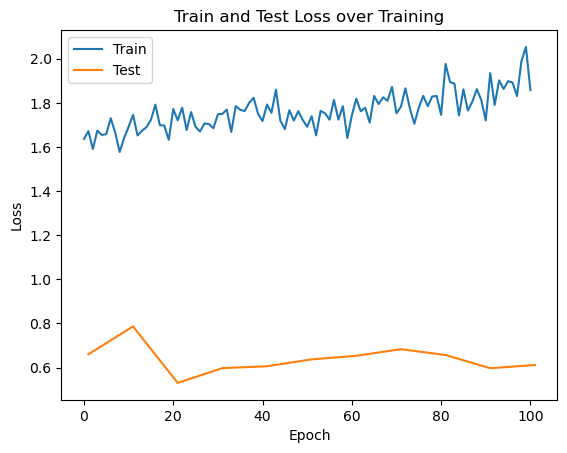

In [9]:
# Set dropout probabilities
p_drop_input = 0.2
p_drop_hidden = 0.5

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model with dropout
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                # feed input through model without dropout during testing
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.legend()


* During evaluation or testing, we want to assess the performance of the network without dropout regularization. We want to see how well the network performs when all neurons are active and producing their full outputs. Therefore, we evaluate the test loss using the model configuration without dropout.

* The test loss, which indicates how well the model performs on unseen data is consistently lower in Section 2 than it is in Section 1, indicating that the dropout model is more effective in reducing overfitting and improving generalization.

## 3 Parametric Relu

Instead of a simple rectify mapping (aka rectified linear unit; Relu) we want to add a parametric
Relu that maps every element xi of the input X to
        
        xi →   {xi      if xi > 0
                aixi    if xi ≤ 0}

A detailed description can be found in the paper Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification (see http://arxiv.org/pdf/1502. 01852.pdf). The crux of this method is the learnable weightvector a that needs to be adjusted during training. Define the function:

        def PRelu(X,a): ...
        
that creates a PRelu layer by mapping X → PRelu(X).
Incorporate the parameter a into the params list and make sure that it is optimized during training.


Task: Compare the results with the previous models.

## 4 Convolutional layers